In [7]:
from utils.modelUtils import load_sam
from classes.SAMClass import SAMWrapper, SAMInferer

from utils.base_classes import Points
import utils.promptUtils as prUt
import utils.analysisUtils as anUt
from utils.imageUtils import read_im_gt

# Obtain model, image, gt
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'

sam_model = load_sam(checkpoint_path, device)
sam_wrapper = SAMWrapper(sam_model, device)
sam_inferer = SAMInferer(sam_wrapper, device)

# Load in image, label, prompt
# img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
# img, gt = read_im_gt(img_path, gt_path)

img_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTs/amos_0001.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTs/amos_0001.nii.gz'
img, gt = read_im_gt(img_path, gt_path, 2)


In [8]:
# Experiment: 2d bounding box per slice with foreground
box_prompt = prUt.get_minimal_boxes_row_major(gt, 3, 3)

segmentation = sam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

Performing inference on slices: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]


0.8690242677507083

In [6]:
# Experiment: n randomly sampled points from foreground
seed = 11121
n=5
pts_prompt = prUt.get_pos_clicks2D_row_major(gt, n, seed = seed)
segmentation = sam_inferer.predict(img, pts_prompt)
anUt.compute_dice(segmentation, gt)

Performing inference on slices: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


0.11034912643757769

In [ ]:
# Experiment: Given n equally spaced slices, pick a 'central point' and interpolate a curve (DoF: linear vs cubic) between teh points
n = 5
interpolation = 'linear'
simulated_clicks = prUt.get_fg_points_from_cc_centers(gt, n)
coords = prUt.interpolate_points(simulated_clicks, kind = interpolation).astype(int)
pts_prompt = Points({'coords': coords, 'labels': [1]*len(coords)})
segmentation = sam_inferer.predict(img, pts_prompt)

anUt.compute_dice(segmentation, gt)

Performing inference on slices: 100%|██████████| 21/21 [00:14<00:00,  1.45it/s]


0.05799243674780155

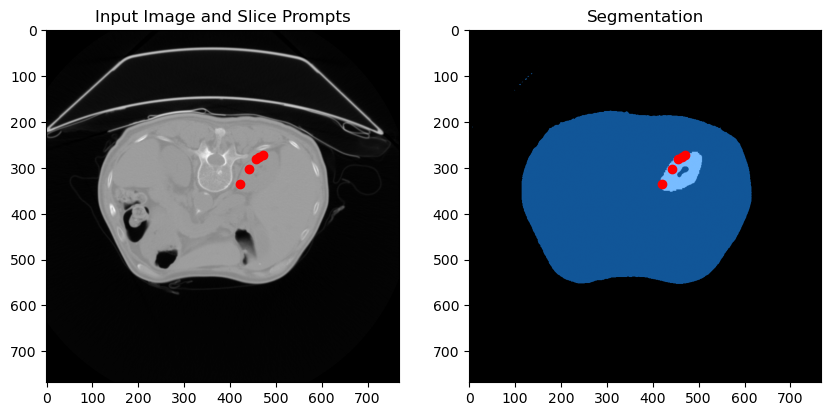

0.06284839127711948

In [ ]:
# Slice visualisation (points):
slice_idx = 68
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, pts_prompt= pts_prompt)b

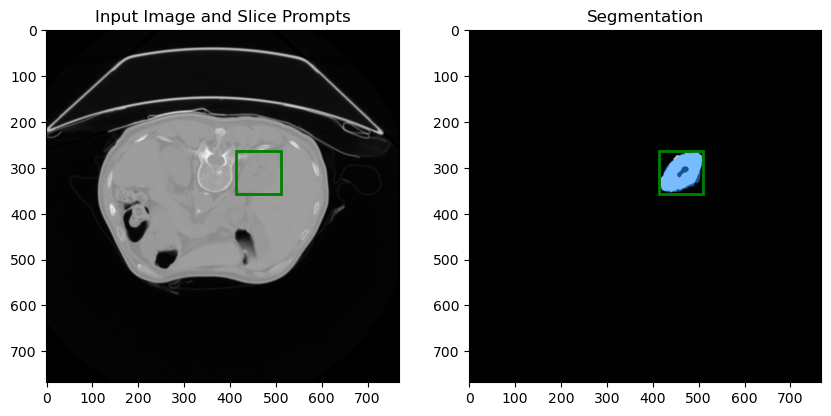

0.9066666666666666

In [5]:
# Slice visualisation (boxes):
slice_idx = 68
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, box_prompt= box_prompt)